In this project I am going to try to design and train a CNN to classify different pokemon from images. Due the few images available per class, I will use Image Augmentation to feed the CNN with more examples of each class/pokemon.

In [46]:
# Importing the necessary packages
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [47]:
# For the reproducibility of the results
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
# Image Generator for the train set
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest')
# Image Generator the validation set
test_datagen = ImageDataGenerator(
        rescale=1./255)
# Load the train images
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')
# Load the validation images
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')

Found 100 images belonging to 7 classes.
Found 28 images belonging to 7 classes.


We have 100 images for training and 28 for validating.

In [49]:
# Number of different classes
train_size = train_generator.num_classes

To better understand Image Augmentation, let's apply the train Image Generator to a single image and observe the different transformations:

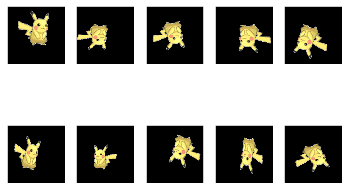

In [50]:
# Preview of the augmentated process in a Pikachu image
img = load_img('data/train/pikachu/pikachu.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 1
for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,5,i)
        plt.imshow(batch.reshape((120, 120, 3)))
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        i += 1
        if i>10:
                break

Now we define the model:

In [71]:
# Defining the model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, 3, input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_size, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

We can review the model summary:

In [72]:
# Preview the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 18, 18, 256)     

As we have very few images per class, and locally I train the model on GPU, we can train the model for 200 epochs:

In [73]:
batch_size = 32
# Training the model
history = model.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator)

.6900 - val_loss: 0.5882 - val_accuracy: 0.7143
Epoch 61/200
7/7 [==============================] - 1s 101ms/step - loss: 0.5686 - accuracy: 0.7000 - val_loss: 0.2824 - val_accuracy: 0.7857
Epoch 62/200
7/7 [==============================] - 1s 100ms/step - loss: 0.5072 - accuracy: 0.7300 - val_loss: 0.6428 - val_accuracy: 0.7500
Epoch 63/200
7/7 [==============================] - 1s 107ms/step - loss: 0.5987 - accuracy: 0.6600 - val_loss: 0.2434 - val_accuracy: 0.7500
Epoch 64/200
7/7 [==============================] - 1s 110ms/step - loss: 0.5848 - accuracy: 0.6900 - val_loss: 0.2759 - val_accuracy: 0.6786
Epoch 65/200
7/7 [==============================] - 1s 104ms/step - loss: 0.5303 - accuracy: 0.7400 - val_loss: 0.6447 - val_accuracy: 0.8571
Epoch 66/200
7/7 [==============================] - 1s 103ms/step - loss: 0.5398 - accuracy: 0.7300 - val_loss: 0.2595 - val_accuracy: 0.7857
Epoch 67/200
7/7 [==============================] - 1s 100ms/step - loss: 0.4945 - accuracy: 0.7800 

Once trained, we plot the accuracies evolution with epochs:

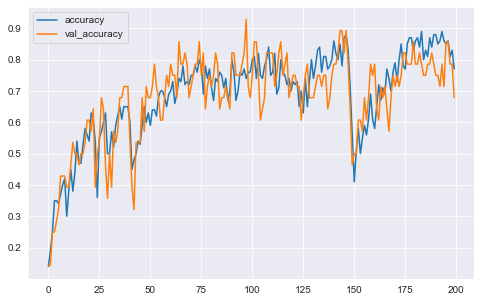

In [74]:
# View the evolution of the accuracy and val_accuracy with training epochs
sns.set_style('dark')
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

And we are ready to predict some labels using the trained model in 8 new images, one per class with an extra one:

<Figure size 720x360 with 0 Axes>

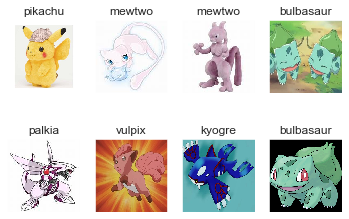

In [75]:
# Predict the class for 8 test images
image_list = os.listdir('data/test/')
plt.figure(figsize=(10,5))
f, ax = plt.subplots(2, 4)
i=0
for image in image_list:
    img = load_img('data/test/'+ image, target_size=(150, 150))
    x = img_to_array(img)
    plt.subplot(2,4 ,i+1)
    plt.imshow(img)
    x = x/255.
    x = np.expand_dims(x, axis=0)
    pred = model.predict_classes(x)
    plt.title(list(train_generator.class_indices)[int(pred)])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    i+=1

Nearly perfect. The model correctly predicted all the pokemon images, even the one with two bulbasaur, but it has not distinguished between mew and mewtwo, which is probably the main difficulty of this task given the large differences between the other classes.

Obviously, this is a simple project that could be harder to solve incresing the number of classes (pokemons), or choosing more similar pokemon, as in the mew/mewtwo example.